# TimeSeries RNN for Predicting Delhi's Temperature

## Setup - Requires Python 3.7 or above

In [ ]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow >= 2.8

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Predefine font values

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Making sure there's a GPU

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


## Dataset Selection


Converting data file to dataframe, index by date, remove duplicates.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/CSC402/Chapter15/DailyDelhiClimateTrain.csv")
df
# axis = 1 means column
# df = df.drop(df.columns[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13]], axis=1)
# df = df.sort_values("month").set_index("month")
# df = df.drop_duplicates()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
# Convert "date" column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' column as the index of DataFrame
df.set_index('date', inplace=True)

In [ ]:
print("Standard Deviation of temp: ", df['meantemp'].std())

Standard Deviation of temp:  7.348102725432476


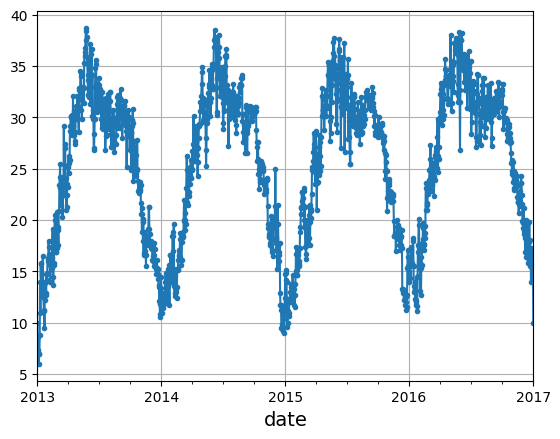

In [ ]:
import matplotlib.pyplot as plt

df['meantemp'].plot(grid=True, marker=".")
xlabel = "Date"
ylabel = "Mean temperature in Celcius"
plt.show()

# Naive Forecasting

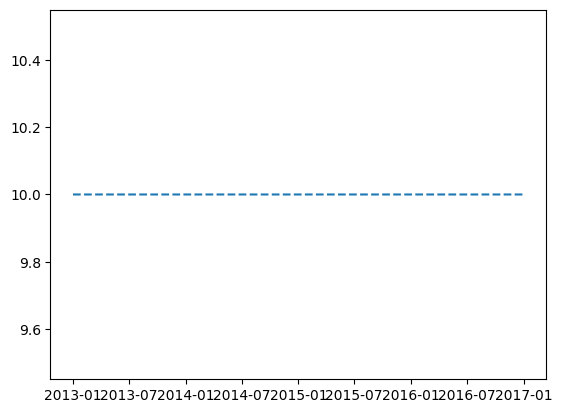

In [ ]:
# Predict next week by looking at last week
last_observation = df['meantemp'].iloc[-1]

naive_forecast = [last_observation] * len(df)

plt.plot(df.index, naive_forecast, label='Naive Forecast', linestyle='--');

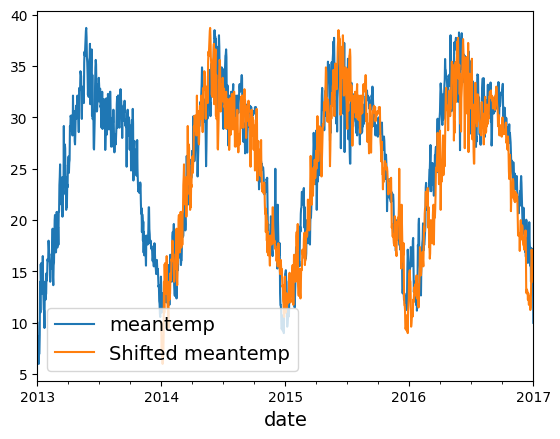

In [ ]:
# Plotting mean temp data
df['meantemp'].plot(legend=True)

# Plotting the mean temp data shifted by a year
diff_7 = df['meantemp'].shift(365)
diff_7.plot(legend=True, label='Shifted meantemp')
plt.show()

In [ ]:
# MAE
naive_diff_temp = diff_7 - df['meantemp']

print(naive_diff_temp.abs().mean())

2.556797180195331


# ARIMA

In [ ]:
# Install statsmodels library
if "google.colab" in sys.modules:
  %pip install -q -U statsmodels

In [ ]:
# Importing ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Doing daily predictions
origin, today = "2013-01-01", "2017-01-01"
meantemp_series = df.loc[origin:today]["meantemp"].asfreq("D")

model = ARIMA(meantemp_series)
model = model.fit()
y_pred = model.forecast()

print(y_pred)

2017-01-02    25.495516
Freq: D, dtype: float64


In [ ]:
# Using Jan. 1, 2017 to predict Jan. 2, 2017
y_pred[0]

25.495516234186145

In [ ]:
y_pred = model.forecast(steps=2) # Predicting 2 days in advance

y_pred[1]

25.495516234186145

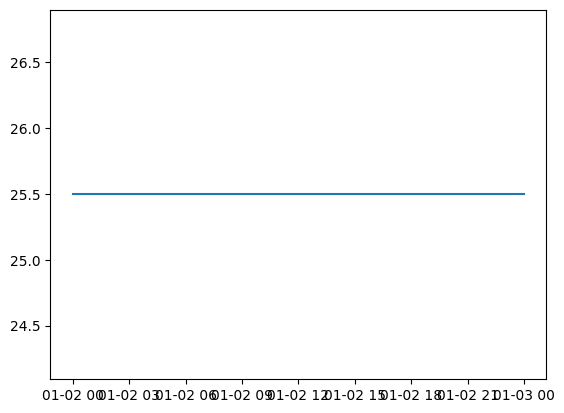

In [ ]:
plt.plot(y_pred);

# Simple RNN

In [ ]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

Splitting the data into training, validation, and testing data

In [ ]:
temp_train = df['meantemp']['2013-01-01' : '2015-01-01']

temp_validate = df['meantemp']['2015-01-02' : '2017-01-01']

temp_test = pd.read_csv("/content/drive/MyDrive/CSC402/Chapter15/DailyDelhiClimateTest.csv")


In [ ]:
# Convert "date" column to datetime format
temp_test['date'] = pd.to_datetime(temp_test['date'])

# Set 'date' column as the index of DataFrame
temp_test.set_index('date', inplace=True)

In [ ]:
temp_test = temp_test['meantemp']

In [ ]:
temp_train.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64

In [ ]:
temp_validate.head()

date
2015-01-02    14.875
2015-01-03    15.125
2015-01-04    14.125
2015-01-05    14.000
2015-01-06    12.000
Name: meantemp, dtype: float64

In [ ]:
temp_test.head()

date
2017-01-01    15.913043
2017-01-02    18.500000
2017-01-03    17.111111
2017-01-04    18.700000
2017-01-05    18.388889
Name: meantemp, dtype: float64

In [ ]:
seq_length = 56 # 56 time stamp

# Training dataset
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    temp_train.to_numpy(), targets=temp_train[seq_length:],
    sequence_length=seq_length, batch_size=32, shuffle=True)

# Validation dataset
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    temp_validate.to_numpy(), targets=temp_validate[seq_length:],
    sequence_length=seq_length, batch_size=32)

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
len(train_ds)

22

In [ ]:
valid_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# Use .Dense to make predictions better - more neurons = better prediction
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])
# Predicting 1 element

In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
# Compiles, fits, evaulates model
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
22/22 [==============================] - 5s 119ms/step - loss: 9.8806 - mae: 10.3674 - val_loss: 5.4627 - val_mae: 5.9304
Epoch 2/500
22/22 [==============================] - 1s 38ms/step - loss: 5.9043 - mae: 6.3871 - val_loss: 5.2164 - val_mae: 5.7071
Epoch 3/500
22/22 [==============================] - 1s 38ms/step - loss: 5.6505 - mae: 6.1344 - val_loss: 4.9886 - val_mae: 5.4652
Epoch 4/500
22/22 [==============================] - 1s 42ms/step - loss: 5.6328 - mae: 6.1148 - val_loss: 5.5267 - val_mae: 6.0170
Epoch 5/500
22/22 [==============================] - 1s 35ms/step - loss: 5.6427 - mae: 6.1298 - val_loss: 5.2838 - val_mae: 5.7750
Epoch 6/500
22/22 [==============================] - 1s 47ms/step - loss: 5.4000 - mae: 5.8792 - val_loss: 4.9211 - val_mae: 5.3995
Epoch 7/500
22/22 [==============================] - 1s 58ms/step - loss: 5.4400 - mae: 5.9215 - val_loss: 4.9461 - val_mae: 5.4271
Epoch 8/500
22/22 [==============================] - 2s 72ms/step - loss: 

5381829.738616943

mae at the end for Simple RNN is 5.1149, loss is 4.6376, value loss is 4.9043

# Deep RNNs

In [ ]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compiles, fits, and evaluates model
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
22/22 [==============================] - 5s 82ms/step - loss: 9.6240 - mae: 10.1156 - val_loss: 5.1497 - val_mae: 5.6401
Epoch 2/500
22/22 [==============================] - 1s 50ms/step - loss: 5.4044 - mae: 5.8890 - val_loss: 5.1814 - val_mae: 5.6714
Epoch 3/500
22/22 [==============================] - 1s 51ms/step - loss: 5.4408 - mae: 5.9266 - val_loss: 5.0691 - val_mae: 5.5584
Epoch 4/500
22/22 [==============================] - 1s 52ms/step - loss: 5.4287 - mae: 5.9131 - val_loss: 4.9704 - val_mae: 5.4556
Epoch 5/500
22/22 [==============================] - 1s 49ms/step - loss: 5.4586 - mae: 5.9393 - val_loss: 4.9334 - val_mae: 5.4122
Epoch 6/500
22/22 [==============================] - 1s 50ms/step - loss: 5.4005 - mae: 5.8866 - val_loss: 5.0253 - val_mae: 5.5138
Epoch 7/500
22/22 [==============================] - 2s 95ms/step - loss: 5.3582 - mae: 5.8404 - val_loss: 5.5253 - val_mae: 6.0156
Epoch 8/500
22/22 [==============================] - 3s 96ms/step - loss: 5

5381066.799163818

Deep RNN mae = 5.3811, loss = 4.9022, value loss = 5.0211

# LSTM Model

In [ ]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))


In [ ]:
# Define LSTM model

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [ ]:
lstm_model.layers[1].input_shape

(None, None, 32)

In [ ]:
fit_and_evaluate(lstm_model, train_ds, valid_ds, learning_rate=0.05, epochs=5)

Epoch 1/5
22/22 [==============================] - 4s 65ms/step - loss: 11.9488 - mae: 12.4391 - val_loss: 6.9062 - val_mae: 7.3945
Epoch 2/5
22/22 [==============================] - 1s 41ms/step - loss: 6.3244 - mae: 6.8130 - val_loss: 5.9865 - val_mae: 6.4746
Epoch 3/5
22/22 [==============================] - 1s 41ms/step - loss: 5.5167 - mae: 6.0016 - val_loss: 5.6969 - val_mae: 6.1844
Epoch 4/5
22/22 [==============================] - 1s 37ms/step - loss: 5.4433 - mae: 5.9276 - val_loss: 5.6135 - val_mae: 6.1027
Epoch 5/5
22/22 [==============================] - 0s 16ms/step - loss: 5.1234 - mae: 5.6130


5612957.954406738

LSTM mae = 5.6130, loss = 5.1234, val_loss = 5.1234 at last epoch.

# Evaluating RNN Models
**MAE** = Mean Average Error


**RSME** = Root Square Mean Error

In [ ]:
# Simple RNN mae, loss, val_loss
simple_RNN_mae = 5.1149 # Taken from last epoch
simple_RNN_loss = 4.6376
simple_RNN_val_loss = 4.9043

In [ ]:
# Deep RNN mae, loss, val_loss
deep_RNN_mae = 5.3811 # Taken from last epoch
deep_RNN_loss = 4.9022
deep_RNN_val_loss = 5.0211

In [ ]:
#LSTM mae, loss, val_loss
lstm_mae = 5.6130
lstm_loss= 5.1234
lstm_val_loss = 5.1234

Now we're going to compare each of the mae's, losses and value of losses.

In [ ]:
import numpy as np
mae_array = np.array([simple_RNN_mae, deep_RNN_mae, lstm_mae])
loss_array = np.array([simple_RNN_loss, deep_RNN_loss, lstm_loss])
val_loss_array = np.array([simple_RNN_val_loss, deep_RNN_val_loss, lstm_val_loss])
model_array = np.array(['Simple RNN', 'Deep RNN', 'LSTM'])

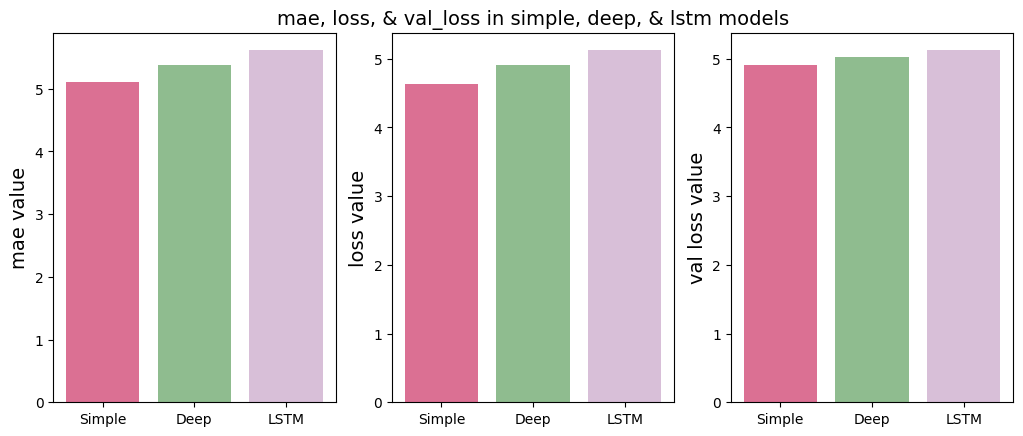

In [ ]:
# Plotting error rates separately
plt.subplot(131) # mae plot
plt.bar(np.array(['Simple', 'Deep', 'LSTM']), mae_array, color=['palevioletred', 'darkseagreen', 'thistle'])
plt.ylabel('mae value')

# Loss plot
plt.subplot(132)
plt.bar(np.array(['Simple', 'Deep', 'LSTM']), loss_array, color=['palevioletred', 'darkseagreen', 'thistle'])
plt.title('mae, loss, & val_loss in simple, deep, & lstm models')
plt.ylabel('loss value')

# Loss val plot
plt.subplot(133)
plt.bar(np.array(['Simple', 'Deep', 'LSTM']), val_loss_array, color=['palevioletred', 'darkseagreen', 'thistle'])
plt.ylabel('val loss value')

# Showing the plot
plt.subplots_adjust(left=0.5, right=2)
plt.show()

So, in this case, the Deep RNN actually has a higher mean average error, a higher loss measurement, and a higher value loss measurement, which is interesting, because I would have assumed the RNN model with multiple layers (Deep RNN) would have predicted values better.

Simple RNN, which has only one layer of neurons to learn with, performed better here. Perhaps, since this dataset is fairly regular in its patterns, the simple model performed better on the dataset because the dataset itself is simple. On the same wavelength, the Deep RNN model has many parameters and is prone to overfitting. Thus, it's reasonable to conclude the Simple RNN performed better than the Deep RNN due to the lack of complexity in the weather dataset that this model was expecting.

# References
- Chapter 15 of textbook
- Google colab file of chapter 15